# MNIST Dataset Introduction

In [182]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [183]:
X, y = mnist.data, mnist.target

In [184]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [185]:
X.shape

(70000, 784)

In [186]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [187]:
y.shape

(70000,)

There are 70,000 images, each with 784 features (28 x 28 pixels)

In [188]:
# show the image of one of the data
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

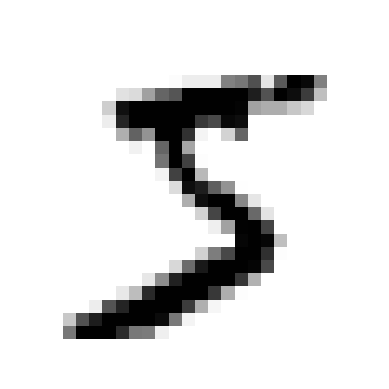

In [189]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [190]:
y[0]

'5'

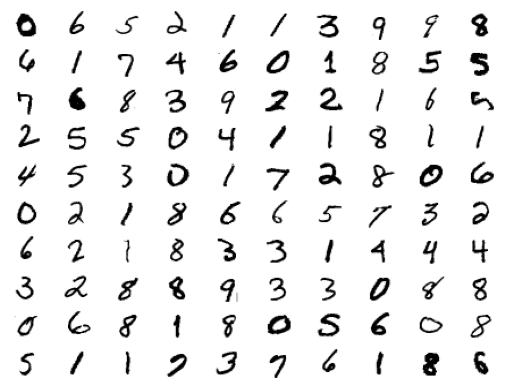

In [191]:
# to show 100 random digits from MNIST
import numpy as np

for i in range(1,101):
    plt.subplot(10, 10, i)  # 2 rows, 2 columns, first position
    ind = np.random.randint(1,70000)
    image = X[ind].reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plt.show()        

In [192]:
# Separate the training and testing data set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In this instance, the training data set has been shuffled and guaranteed that all cross-validation folds will be similar (where one fold has missing digits).
In other instances, it is imperative that we shuffle the data so some algorithms do not perform poorly when they receive many similar instances in a row.

# Training a Binary Classifier

First, simplify the problem to only try and identify 1 digit.

In [20]:
y_train_5 = (y_train =='5')
y_test_5 = (y_test == '5')

In [21]:
# Start with the Stochastic Gradient Descent Classifier
# It is capable of handling very large datasets efficiently.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
sgd_clf.predict([X[0]])

array([ True])

# Performance Measures for Classification

## Accuracy (via Cross-Validation)

In [26]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [27]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [28]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

The above shows that even a dummy classifier that classifies all the images to the most frequent class managed to perform at 90%! (most likely since 10% of the images are 5s).

Hence, accuracy is generally not the preferred performance measure for classifiers, especially when delaing with skewed datasets.

In [ ]:
### how to implement cross-validation yourself
# stratifiedkfold performs stratified sampling to produce
# folds that contain a representative ratio of each class
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is not already shuffled

for train_index , test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train [test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.95035
0.96035
0.9604


## Confusion Matrices

In [ ]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the predictions made on each test fold
# rather than the scores
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_predict)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row represents an *actual class* <br>
Each column represents a *predicted class* <br>

687 -> Non-5s that are classified as 5s (type 1 error, false positives) <br>
1891 -> 5s that are classified as non-5s (type 2 error, false negative)

## Precision and Recall

Accuracy of Positive Predictions / Precision = TP / (TP + FP) <br>

True Positive Rate / Sensitivity / Recall = TP / (TP + FN) <br>
Think of it as how much of the actual positives were predicted as positives;<br> aka how much of the actual positive the model can **RECALL**


In [32]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

F1 score as the *harmonic mean* of precision and recall. Harmonic here means that low values are given more weight. Hence, F1 score will only be high if both recall and precision are high!

<img src="https://framerusercontent.com/images/1NNVbuTCbyaX2tWbtyErU4vFpOk.webp" alt="Description of the image">

In [35]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7325171197343847

Unfortunately f1 score favors classifiers that have similar precision and recall.
Hence the preference for metric will depends on the use case.

In addition, increasing precision reduces recall, and vice versa, aka precision / recall trade-off (either make a model that is really good at getting high true positive accuracy, or a model that can recall the positive class)

<br>

Is this also due to how the SGD Classifier works?

In [36]:
y_scores = sgd_clf.decision_function([X[0]])
y_scores

array([2164.22030239])

In [38]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [40]:
# To decide which threshold to use, use the cross_val_predict() function
# and ask for the decision scores, instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method ="decision_function")
                            # previously the method parameter was not specified

In [41]:
# then use the precision_recall_curve() function to compute the precision and recall
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

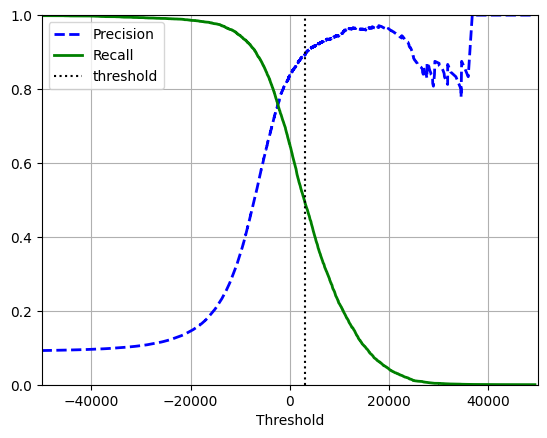

In [47]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0 , "k", "dotted", label="threshold")
plt.grid()
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.xlim(-50000, 50000)
plt.legend()
plt.show()


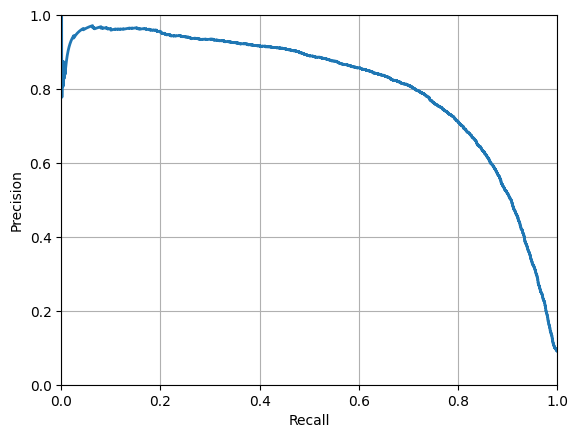

In [49]:
# We can also plot the precision directly against recall
plt.plot(recalls, precisions, linewidth = 2, label ="Precision/Recall curve")
plt.ylabel("Precision")
plt.ylim(0,1)
plt.xlabel("Recall")
plt.xlim(0,1)
plt.grid()
plt.show()

In [51]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.019499144183)

In [52]:
y_train_pred_90 = (y_scores >=threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [53]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC (Receiver Operating Characteristics) Curve

Plotting True Positive Rate (Recall) against False Positive Rate (Fall-out).

Fall out ratio -> ratio of negative instances that are incorrectly classified as positive (1 - True Negative Rate).

True Negative Rate / Specificity -> Negative instances correctly classified as negative

In [55]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
# In ROC case, the threshold are listed in decreasing order
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

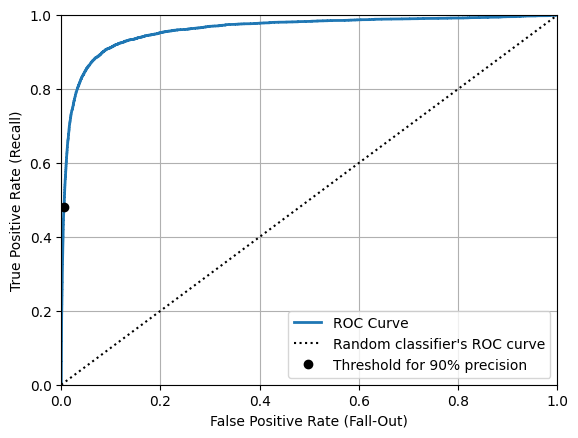

In [58]:
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0,1], [0,1], "k:", label = "Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label ="Threshold for 90% precision")
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.ylabel("True Positive Rate (Recall)")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.show()

In [59]:
# Calculate the Area Under the Curve (AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [60]:
# Improving the model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# RandomFOrest does not have the decision_function method
# so we use the predict_proba method
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method ="predict_proba")

In [61]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [62]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)

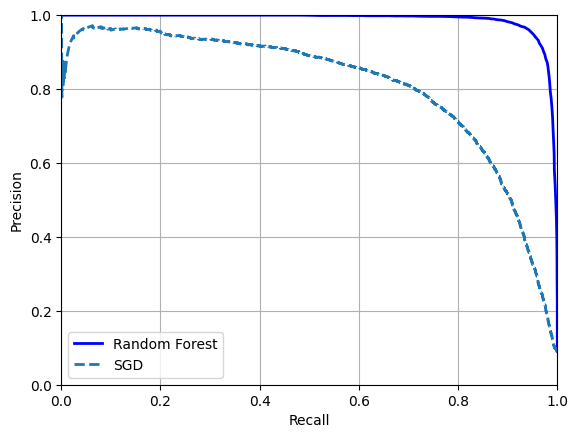

In [64]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth = 2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.ylim(0,1)
plt.xlim(0,1)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.grid()
plt.show()

In [65]:
y_train_pred_forest = y_probas_forest[:,1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9270445185330457

In [68]:
precision_score(y_train_5, y_train_pred_forest)

0.9895331798199707

In [69]:
recall_score(y_train_5, y_train_pred_forest)

0.8719793396052389

In [66]:
# ROC Curve uses the scores values!
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983296721818179)

# Multiclass Classification

Strategies for multiclass
1. *One-versus-the-rest* (OvR) or *One-versus-all* (OvA), for each of the class, train a binary classifier, then when classifying, obtain the decision score from each classifier for that image and select the class with the highest score

2. *One-versus-one* (OvO), traing a binary classifier for every pair of classifiers, getting a total of N * (N-1) / 2 classifiers. While it scales horribly, the advantage is that each classifier only needs to be trained on the part of the trianing set containing the 2 classes that it must distinguish.

The choice of strategy will depend on the algorithms that is employed. For algorithms that scale poorly with the size of training set, OvO is preferred. While for binary classification, OvR is preferred.

In [70]:
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [72]:
svm_clf.predict([X[0]])

array(['5'], dtype=object)

Behind the scenes, SVM is running the OvO strategy and taking the highest score from the 45 binary classifiers.

In [76]:
# The scores below indicate the number of won duels plus or minus a small tweak
# to break ties
some_digit_scores = svm_clf.decision_function([X[0]])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [77]:
# use the argmax() function to find the corresponding id for the max score
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [78]:
# to look for the mapping between index and class
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [79]:
svm_clf.classes_[class_id]

'5'

To force sklearn to use the OvO or OvR, use the following method

In [80]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [81]:
ovr_clf.predict([X[0]])

array(['5'], dtype='<U1')

In [82]:
len(ovr_clf.estimators_)

10

In [ ]:
# now use the SGDClassifier on the multiclass dataset
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

In [84]:
sgd_clf.predict([X[0]])

array(['3'], dtype='<U1')

In [85]:
sgd_clf.decision_function([X[0]]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [86]:
# Use the accuracy metric here since there are roughly the same number
# of images in each class
cross_val_score(sgd_clf,X_train, y_train, cv=3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [87]:
# Scale the inputs to increase the accuracy even further
# Why does this work?
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

# In between this step and error analysis, you should try out multiple models, shortlist the best ones, fine tune their hyperparameters using GridSearchCV and automate as much as possible.

# Error Analysis

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

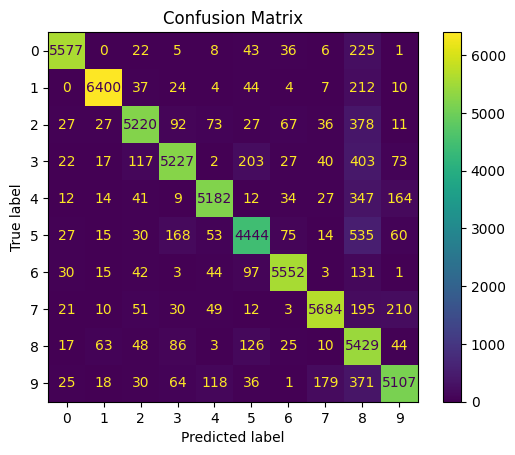

In [103]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix")
plt.show()

Normalize the confusion matrix to standardize in case the model made more errors on specific classes or there are fewer of a specific class.

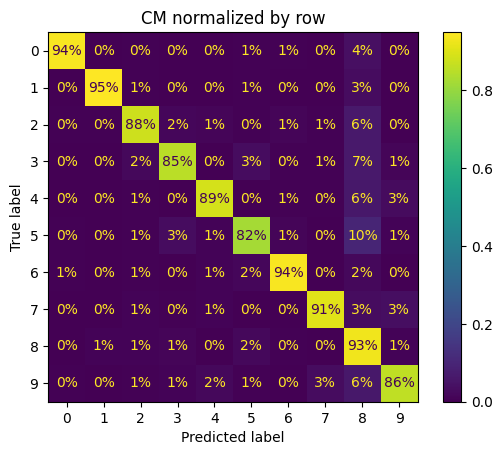

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train,
                                        y_train_pred,
                                        normalize = "true",
                                        values_format = ".0%")
plt.title("CM normalized by row")
plt.show()

Make the errors stand out more by putting zero weight on the correct predictions.

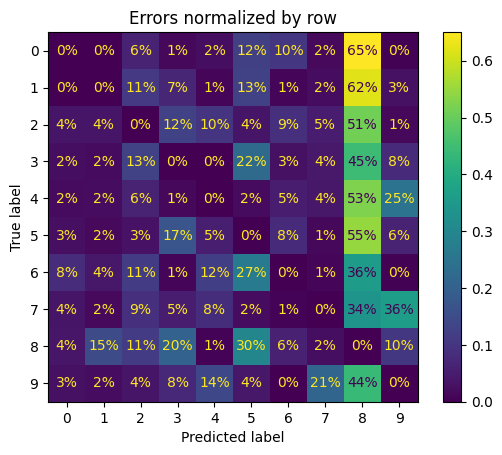

In [100]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight = sample_weight,
    normalize = "true",
    values_format = ".0%"
)
plt.title("Errors normalized by row")
plt.show()

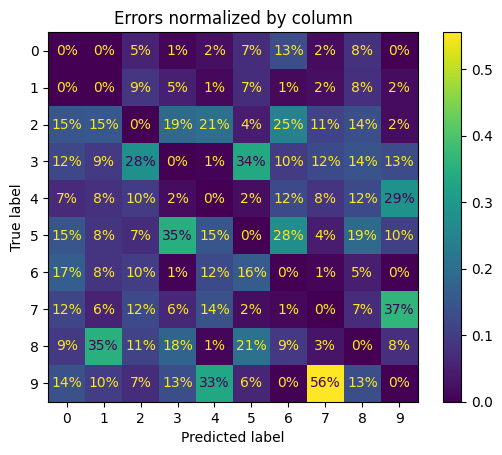

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    sample_weight = sample_weight,
    normalize = "pred", # change from true to pred to normalize by column
    values_format = ".0%"
)
plt.title("Errors normalized by column")
plt.show()

Since there are a lot of misclassification as 8s, try to improve the model by decreasing the amount of false 8s, specifically by:
1. Obtaining more data of 8 look-alikes but not real 8s
2. Engineer new features to help the classifier (looking at the number of loops in 8, 6 and 5)
3. Preprocess the image using Scikit-image, pillow or OpenCV to make some patterns stand out more.

In [104]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

We can try to force the model to learn and be more tolerant to variations such as augmenting the training set with slightly shifted and rotated variants of the training images with the use of *data augmentation* (covered later)

# Multilabel Classification

In [105]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >='7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel) # not all classifiers support multilabel

KNeighborsClassifier()

In [107]:
knn_clf.predict([X[0]])

array([[False,  True]])

In [109]:
# Evalute the multilabel classifier using the F1 score
# Measure the F1 score for each individual label then simply compute the average
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score (y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

This assumes that all labels are equally important (may not necessarily be the case). One simple option is to give each label a weight equal to its support (number of instance with that target label). We can achieve this by setting average ="weighted" under f1_score() function.

In [110]:
# Use the ChainClassifier to allow for multilabel for algorithms
# that doesn't support multilabel classification by default
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state = 42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [111]:
chain_clf.predict([X[0]])

array([[0., 1.]])

# Multioutput Classification

A generalization of multilabel classification where each label can me multiclass (i.e. have more than 2 possible values)

In [116]:
np.random.seed(42)
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

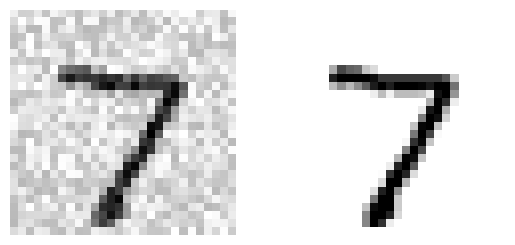

In [119]:
# Check the first output from the y_test_mod and y_test
plt.subplot(1, 2, 1)  # 1 rows, 2 columns, first position
plot_digit(X_test_mod[0])
# ind = np.random.randint(1,70000)
# image = X[ind].reshape(28,28)
# plt.imshow(image, cmap="binary")
plt.axis("off")

plt.subplot(1, 2, 2)  # 1 rows, 2 columns, first position
plot_digit(X_test[0])
# ind = np.random.randint(1,70000)
# image = X[ind].reshape(28,28)
# plt.imshow(image, cmap="binary")
plt.axis("off")

plt.show()        


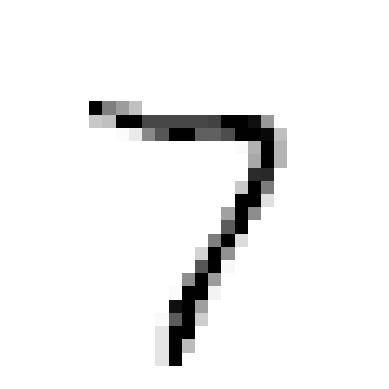

In [120]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

# Exercises

## 1. Classifier for MNIST data set with 97% accuracy on test set
Hint: KNeighborsClassifier works quite well, but need to find a good hyperparameter under weights and n_neighbors

In [123]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# define the KNN Classifier
knn = KNeighborsClassifier()
# Define the scaler
scaler = StandardScaler()
# Define the parameters that should be iterated through
param_grid = {"n_neighbors": range(5,10),
              "weights":["uniform", "distance"]}

# fit and transform X_train to be scaled
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
# define the gridsearch
grid_search = GridSearchCV(knn,
                           param_grid,
                           cv=10,
                           scoring="accuracy")

# run the grid_search under X_train_scaled and y_train
grid_search.fit(X_train_scaled, y_train)
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 10),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [124]:
grid_search.best_params_

{'n_neighbors': 6, 'weights': 'distance'}

In [125]:
import pandas as pd
cv_res = pd.DataFrame(grid_search.cv_results_)

In [127]:
cv_res.sort_values(by="mean_test_score", ascending = False, inplace = True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,0.169840,0.003556,2.129902,0.021937,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.944833,0.942833,0.940000,0.956833,0.950833,0.946000,0.941667,0.941833,0.942833,0.956667,0.946433,0.005884,1
1,0.174160,0.013856,2.166389,0.101269,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.944833,0.942333,0.939500,0.956000,0.949333,0.946000,0.944167,0.942000,0.941667,0.956167,0.946200,0.005561,2
7,0.170502,0.005105,2.152077,0.062881,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",0.942833,0.944333,0.936500,0.954167,0.948333,0.943500,0.941500,0.940500,0.941833,0.956333,0.944983,0.005880,3
5,0.170063,0.002039,2.113582,0.025832,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.942833,0.942167,0.937333,0.954000,0.948500,0.943167,0.940500,0.938667,0.942167,0.955500,0.944483,0.005866,4
0,0.169297,0.015256,2.110700,0.084347,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.943167,0.940667,0.937833,0.954500,0.947667,0.944333,0.940000,0.939333,0.938500,0.955167,0.944117,0.006052,5


In [ ]:
# Run the best parameter at the test set
knn_best = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"],
                                weights=grid_search.best_params_["weights"])

knn_best.fit(X_train, y_train)
y_test_pred = knn_best.predict(X_test)
n_correct = sum(y_test_pred == y_test)
print(n_correct / len(y_test_pred)) 

0.9709


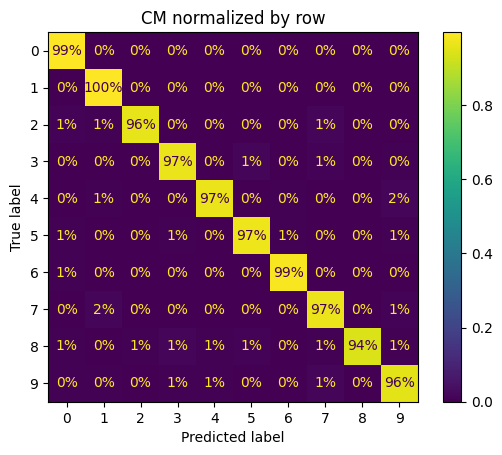

In [129]:
# Create the confusion matrix below
ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_test_pred,
                                        normalize = "true",
                                        values_format = ".0%")
plt.title("CM normalized by row")
plt.show()

The KNN with 6 neighbors and distance weights performed really well, as accuracy for each class seems to be all above 94% with an overall accuracy of 97%!

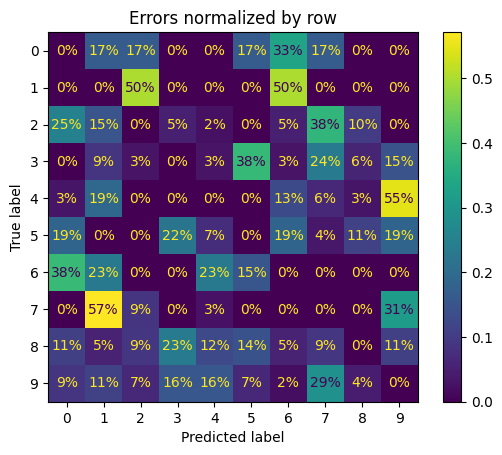

In [130]:
sample_weight = (y_test_pred != y_test)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    sample_weight = sample_weight,
    normalize = "true",
    values_format = ".0%"
)
plt.title("Errors normalized by row")
plt.show()

Looking at the errors, we can see that
- Out of the misclassified 1s, most are predicted as either 2 or 6
- Out of the misclassified 4s, almost half are predicted as 9 (they are quite similar)
- Out of the misclassified 7s, almost half are predicted as 1s (they are quite similar)

## 2. Write a function that can shift an MNUST image in any direction by one pixel. Then for each image in the training set, create 4 shifted copies and add them to the training set. Finally train your best model in this expanded training set and measure its accuracy on the test set. The model performance should be better now! (*data augmentation* example)

In [ ]:
## Potential method without using the scipy image library
# def shift_image(img_array, direction="left"):
#     image = img_array.copy().reshape(28,28)
#     if direction == "left":
#         for i in range(28):
#             if i == 27:
#                 image[:,i] = pd.Series(np.zeros(28)) 
#             else:
#                 image[:,i] = image[:,i+1]
#     elif direction == "right":
#         for i in range(27,0,-1):
#             if i == 0:
#                 image[:,i] = pd.Series(np.zeros(28)) 
#             else:
#                 image[:,i] = image[:,i-1]
#     elif direction == "up":
#         for i in range(28):
#             if i == 27:
#                 image[i] = pd.Series(np.zeros(28)) 
#             else:
#                 image[i] = image[i+1]
#     elif direction == "down":
#         for i in range(27,0,-1):
#             if i == 0:
#                 image[i] = pd.Series(np.zeros(28)) 
#             else:
#                 image[i] = image[i-1]
#     image = image.reshape(784,)
#     return image

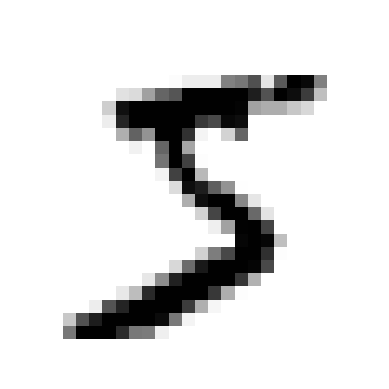

In [ ]:
# plot_digit(X[0])

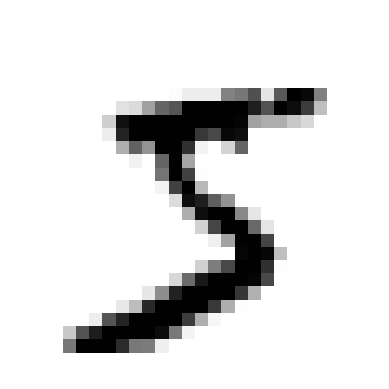

In [ ]:
# plot_digit(shift_image(X[0], "down"))

In [ ]:
# X_train_augment = X_train.copy()
# # possible method but takes way too long
# for i in range(len(X_train)):
#     X_train_augment = np.vstack((X_train_augment, shift_image(X_train[i], "left")))
#     X_train_augment = np.vstack((X_train_augment, shift_image(X_train[i], "right")))
#     X_train_augment = np.vstack((X_train_augment, shift_image(X_train[i], "up")))
#     X_train_augment = np.vstack((X_train_augment, shift_image(X_train[i], "down")))

(60000, 784)

### Answer from textbook

In [241]:
from scipy.ndimage import shift

In [ ]:
# Create function to shift the image using the shift function from scipy.ndimage
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

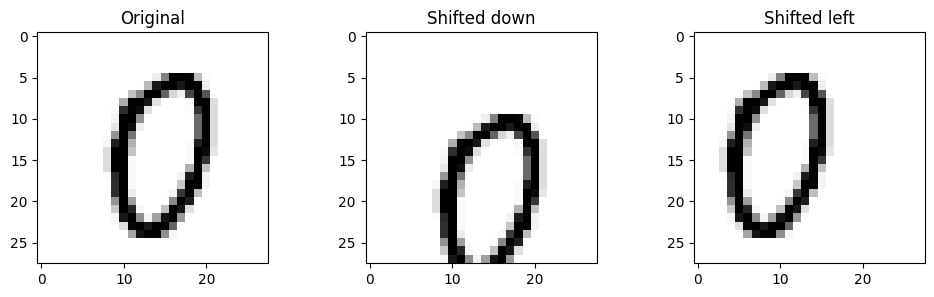

In [ ]:
# testing the function
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
# creating the data
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
# shuffle the newly made data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
# create and train the KNN classifier using the augmented data
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

In [249]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9772

Previously our accuracy was 97.09%. <br>

After data augmentation, our accuracy is 97.72%!

In [251]:
tuned_accuracy = knn_best.score(X_test, y_test)
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -22%


## 3. Tackle the Titanic Dataset! Train a classifier that can predict the Survived columns based on the other columns

Check under 2. Application -> titanic -> dslc_documentation

# 4. Build a spam classifier! <br>
a. Download examples of spam and ham <br>
b. Unzip the datasets and familiarize yourself with the data format. <br>
c. Split the data into training and test set. <br>
d. Write data preparation pipeline to convert each email into a feature vector. <br>

Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello”, “how”, “are”, “you”, then the email “Hello you Hello Hello you” would be converted into a vector [1, 0,0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL”, replace all numbers with “NUMBER”, or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).

e. Try out several classifiers and see if you can build a great spam classifier with both high recall and high precision. <br>

In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import tarfile
import urllib.request

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [3]:
ham_dir, spam_dir = fetch_spam_data()

/var/folders/7j/0rhz18qs4d9dzfjkz9p2xlcr0000gn/T/ipykernel_86420/2426298476.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


Load all the emails

In [4]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [43]:
len(ham_filenames)

2500

In [44]:
len(spam_filenames)

500

In [45]:
import email
import email.policy

def load_email(filepath):
    # r: read, b : binary
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [46]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [ ]:
# take a look at one ham example
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [52]:
# take a look at one spam example
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [ ]:
# function to look at structures in the email
def get_email_structure(email):
    if isinstance(email, str):
        return email
    # get_payload() = return the current payload
    # which will be a list of Message objects
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [ ]:
# Counter here acts as a hashmap / dictionary
# that does not return a Value error when a key is not present
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [55]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [56]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

We observe that for ham emails, there are often plain text, while for SPAM there seems to be a lot of html.

In addition, hams seems to have pgp signature, while no spam is.

In [58]:
# looking at email headers
for header, value in spam_emails[0].items():
    print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [61]:
# Split the dataset into training and testing set
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    # delete the head
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    # replace any link html with HYPERLINK
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    # delete any beginning and ending html bracket
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    # replace multiple newlines with a single newline
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7j/0rhz18qs4d9dzfjkz9p2xlcr0000gn/T/ipykernel_86420/3203418293.py:6: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)


In [ ]:
# the get_email_structure(email) == "text/html"
# is important to look at the specific html of a spam email
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [ ]:
# Below is the plain text in a spam email
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Now that we have functions to look at the headers and take out / modify all the HTML headers, we can write a function that takes an email as an input as returns the contents as plain text, whatever format it is

In [68]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        # ignore any content that is not a plain text or html text
        if not ctype in ("text/plain", "text/html"):
            continue

        # try to get the content directly
        try:
            content = part.get_content()
        # if error, then use the get_payload() function
        # error most likely happens because the email is multipart
        except: # in case of encoding issues
            content = str(part.get_payload())
        
        if ctype == "text/plain":
            return content
        else:
            html = content
            
    # if the html list exists, run the html_to_plain_text function
    if html:
        return html_to_plain_text(html)

In [70]:
# Testing the email_to_text function
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Try to add "stemming" using the NLTK library

In [73]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


Also replace the URLs with the word "URL"

In [76]:
import urlextract # may require an Internet connection to download root domain
                  # names

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Create a transformer to convert emails to word counter (done through Python's split (method)). Note that this may not necessarily work for Chinese and Japanese scripts as these languages do not use whitespace to define the word boundaries.

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    # define all the parameters for the stemming and text manipulation options
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    
    def fit(self, X, y=None):
        return self # HAVE TO RETURN SELF
    
    # create the transform function
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            # transform to lower case
            if self.lower_case:
                text = text.lower()
            # replace existing urls links with "URL"
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            # replace any specific numbers with "NUMBER"
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            # remove punctuation marks
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            # create a counter object where the key is each of the word in the text
            word_counts = Counter(text.split())
            # stem when the stemmer object also exists
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    # create the key using the stemmed word
                    stemmed_word = stemmer.stem(word)
                    # increase the counter using the existing count
                    stemmed_word_counts[stemmed_word] += count
                # replace word_counts with stemmed_word_counts
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [79]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

After making the word counts, now we need to convert them to vectors.

For this, build another transformer whose fit() method will build the vocabulary (ordered list of the most common words) and transform() method will use the vocabilary to convert word counts to vectors. Note that the output should be a sparse matrix!

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    # initialize the class and add the vocabulary_size attribute
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    
    def fit(self, X, y=None):
        total_count = Counter()
        # for each dictionary list in X
        for word_count in X:
            # for each word and count under each item
            for word, count in word_count.items():
                # add either the count or max of 10
                total_count[word] += min(count, 10)
        # use the most_common() method under Counter to sort
        # and find the most frequently used word up to the
        # self.vocabulary_size attribute
        most_common = total_count.most_common()[:self.vocabulary_size]
        # create the vocabulary_ attribute where 
        # the word from most_common is the key
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self # HAVE TO RETURN SELF UNDER FIT

    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                # the .get() method is under the dict data structure
                # find the index for the word in the vocabulary_ list
                # if no value to return (word does not exist in the list)
                # then return 0
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        # csr_matrix((data, (row_ind, col_ind)), shape=(M,N))
        # in a way, it will add up all value under the same row and col index
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [81]:
# test if the sparse matrix works
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 20 stored elements and shape (3, 11)>

In [82]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]])

In the sparse matrix above, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. 

You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [83]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

Now train the spam classifier

In [84]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

np.float64(0.985)

Now let's try it on the test set

In [ ]:
from sklearn.metrics import precision_score, recall_score

# note here that we are only using the transform function
# and not the fit_transform function
# as that function will not fit the passed input data
# into the previously defined and transformed matrix
X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%


### As a reminder

Precision : Proportion of True Positive over all Predicted Positives [TP / TP + FP]

Recall : Proportion of True Positive over all the Actual Positive
[TP / TP + FN]